In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

import japanize_matplotlib

import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set(font="IPAexGothic")

from IPython.display import display
import collections
import re
import feather
import codecs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer

In [8]:
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
df_all=pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
df_all.columns=['id','rent','address','access','floor_info','old','direction','square','floor','bath','kitchen','broadcast','facility','parking','neighbors','structure','period']

train_feat4=pd.read_feather('feature4/data/train_feat4_all.ftr')
test_feat4=pd.read_feather('feature4/data/test_feat4_all.ftr').drop('index',axis=1)
df_all_feat4=pd.concat([train_feat4,test_feat4],axis=0,sort=False).reset_index(drop=True)
train_index=len(train_feat4)
test_index=len(test_feat4)

##  連続値を正規分布に載せる

In [40]:
log_cols=['rent','square_num','access_1_distance','access_2_distance','old_num','Square/Room','room_number']
for col in log_cols:
    df_all_feat4[col+'_log']=np.log1p(df_all_feat4[col])  
    train_feat4[col+'_log']=np.log1p(train_feat4[col])  

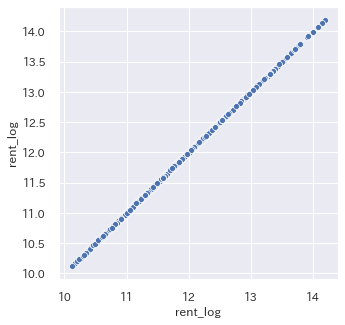

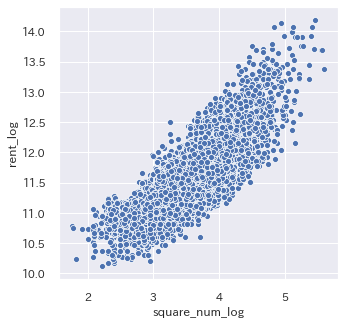

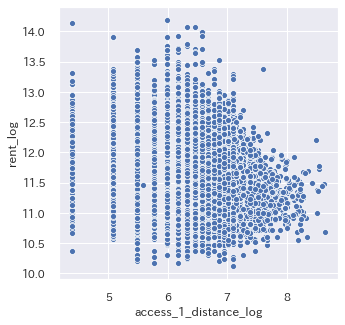

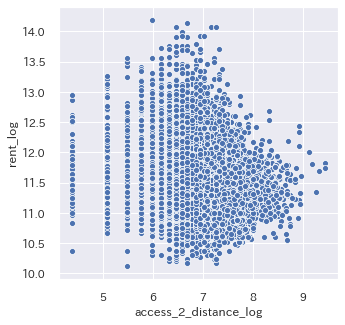

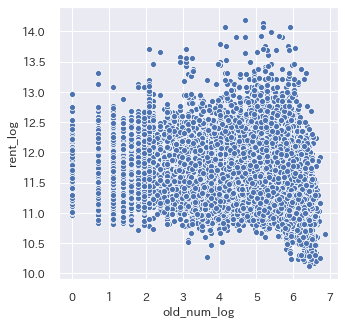

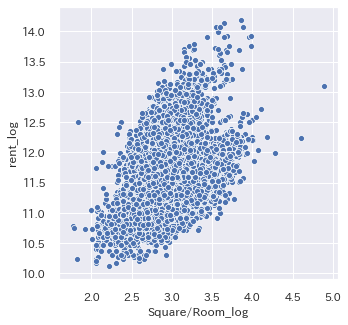

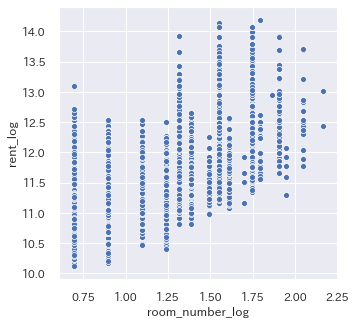

In [41]:
for col in log_cols:
    plt.figure(figsize=(5,5))
    sns.scatterplot(x=col+'_log',y='rent_log',data=train_feat4)
    plt.show()

## もっとも近いアクセスの最寄り駅情報を追加

In [90]:
dist_1over2=df_all_feat4['access_1_distance']<=df_all_feat4['access_2_distance']
dist_2over1=[not i for i in dist_1over2]

df_all_feat4['nearest_distance']=-999
df_all_feat4['nearest_line']=-999
df_all_feat4['nearest_station']=-999

df_all_feat4.loc[dist_1over2,'nearest_distance']=df_all_feat4[dist_1over2]['access_1_distance']
df_all_feat4.loc[dist_2over1,'nearest_distance']=df_all_feat4[dist_2over1]['access_2_distance']
df_all_feat4['nearest_distance_log']=np.log1p(df_all_feat4['nearest_distance'])


df_all_feat4.loc[dist_1over2,'nearest_line']=df_all_feat4[dist_1over2]['access_1_line']
df_all_feat4.loc[dist_2over1,'nearest_line']=df_all_feat4[dist_2over1]['access_2_line']

df_all_feat4.loc[dist_1over2,'nearest_station']=df_all_feat4[dist_1over2]['access_1_station']
df_all_feat4.loc[dist_2over1,'nearest_station']=df_all_feat4[dist_2over1]['access_2_station']


##  最上階かどうかの判定

In [117]:
is_top_room=df_all_feat4['room_floor']==df_all_feat4['building_floor']
df_all_feat4['is_top_room']=0
df_all_feat4.loc[is_top_room,'is_top_room']=1

## 相互作用特徴量を加える

In [147]:
# 自室の階と建物の階の積をとる
tmp=df_all_feat4['room_floor']==-999
tmp2=df_all_feat4['building_floor']==-999
room_building_mul=[ not i for i in (tmp | tmp2)]

df_all_feat4['room_building_mul']=-999
df_all_feat4.loc[room_building_mul,'room_building_mul']=df_all_feat4[room_building_mul]['room_floor']*df_all_feat4[room_building_mul]['building_floor']

In [175]:
df_all_feat4['Square/R']=df_all_feat4['square_num']/df_all_feat4['R']
df_all_feat4['R_K_mul']=df_all_feat4['R']*df_all_feat4['K']
df_all_feat4['R_DK_mul']=df_all_feat4['R']*df_all_feat4['DK']
df_all_feat4['R_LDK_mul']=df_all_feat4['R']*df_all_feat4['LDK']

df_all_feat4['simple_room_sum']=df_all_feat4['R']+df_all_feat4['K']+df_all_feat4['DK']+df_all_feat4['LDK']
df_all_feat4['Square/simple_room_sum']=df_all_feat4['square_num']/df_all_feat4['simple_room_sum']
df_all_feat4['Square/simple_room_sum_log']=np.log1p(df_all_feat4['Square/simple_room_sum'])

In [178]:
df_all_feat4

,id,rent,square_num,access_1_line,access_1_station,access_1_distance,access_2_line,access_2_station,access_2_distance,room_floor,building_floor,underground,total_floor,is_parking_car,is_house_parking_car,is_other_parking_car,parking_number_car,parking_price_car,is_parking_bicycle,is_house_parking_bicycle,is_other_parking_bicycle,parking_number_bicycle,parking_price_bicycle,is_parking_bike,is_house_parking_bike,is_other_parking_bike,parking_number_bike,parking_price_bike,convenience_count,supermarket_count,neighbor_count,デパート,幼稚園・保育園,図書館,ドラッグストア,郵便局,大学,公園,スーパー,銀行,コインパーキング,レンタルビデオ,飲食店,小学校,コンビニ,病院,総合病院,月極駐車場,クリーニング,学校,...,冷房,出窓,地下室,室内洗濯機置場,室外洗濯機置場,専用庭,床下収納,床暖房,排水その他,敷地内ごみ置き場,水道その他,汲み取り,洗濯機置場なし,浄化槽,石油暖房,都市ガス,防音室,longitude,latitude,address_city_enc,address_town_enc,R,K,DK,LDK,S,room_number,Square/Room,mesh_category_enc,others_rent,rent_log,square_num_log,access_1_distance_log,access_2_distance_log,old_num_log,Square/Room_log,room_number_log,nearest_distance,nearest_line,nearest_station,nearest_distance_log,is_top_room,room_building_mul,Square/R,R_K_mul,R_DK_mul,R_LDK_mul,simple_room_sum,Square/simple_room_sum,Square/simple_room_sum_log
0,1,75000.0,20.01,59,433,320.0,25,289,1120.0,1,12,0,12,-999,-999,-999,-999,-999.0,1,1,0,1,-999.0,-999,-999,-999,-999,-999.0,1,2,10,0,0,0,956,1246,461,1103,311,0,0,0,378,495,588,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,35.746889,139.731307,3,1914,1,1,0,0,0,1.454488,13.757421,515,0.0,11.225257,3.044999,5.771441,7.021976,4.779123,2.691746,0.897918,320.0,59,433,5.771441,0,12,20.01,1,0,0,2,10.005,2.398350
1,2,76000.0,16.50,60,97,400.0,32,251,720.0,5,10,0,10,0,0,0,0,-999.0,1,1,0,1,-999.0,0,0,0,0,-999.0,0,1,1,0,0,0,0,0,0,0,1283,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,35.660879,139.778811,1,1368,1,0,0,0,0,1.000000,16.500000,715,0.0,11.238502,2.862201,5.993961,6.580639,6.291569,2.862201,0.693147,400.0,60,97,5.993961,0,50,16.50,0,0,0,1,16.500,2.862201
2,3,110000.0,22.05,17,383,480.0,17,80,560.0,12,15,0,15,1,0,1,1,30000.0,1,1,0,1,-999.0,1,1,0,1,-999.0,2,2,4,0,0,0,0,0,0,0,89,0,0,0,0,0,184,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,35.675199,139.666064,15,2179,1,1,0,0,0,1.454488,15.159977,147,54499.0,11.608245,3.137666,6.175867,6.329721,4.644391,2.782538,0.897918,480.0,17,383,6.175867,0,180,22.05,1,0,0,2,11.025,2.486988
3,4,150000.0,60.48,54,497,720.0,6,235,240.0,3,4,0,4,0,0,0,0,-999.0,0,0,0,0,-999.0,0,0,0,0,-999.0,2,4,6,0,0,0,0,0,0,0,225,0,0,0,0,0,326,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,35.700157,139.650554,11,2824,2,0,0,1,0,3.726175,16.231122,85,0.0,11.918397,4.118712,6.580639,5.484797,5.869297,2.846717,1.553116,240.0,6,235,5.484797,0,12,30.24,0,0,2,3,20.160,3.052113
4,5,74000.0,39.66,13,69,400.0,29,470,560.0,1,2,0,2,1,0,1,1,17000.0,0,0,0,0,-999.0,0,0,0,0,-999.0,1,4,5,0,0,0,0,0,0,0,193,0,0,0,0,0,351,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,35.770009,139.878559,20,2700,2,0,1,0,0,2.996878,13.233772,1093,0.0,11.211834,3.705245,5.993961,6.329721,5.942799,2.655617,1.385514,400.0,13,69,5.993961,0,2,19.83,0,2,0,3,13.220,2.654649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62718,62728,NaN,25.66,25,289,240.0,59,228,720.0,6,8,0,8,0,0,0,0,-999.0,0,0,0,0,-999.0,0,0,0,0,-999.0,2,3,5,0,0,0,0,0,0,0,284,0,0,0,0,0,204,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,35.740681,139.720950,21,79,1,1,0,0,0,1.454488,17.641950,475,907500.0,NaN,3.283164,5.484797,6.580639,1.098612,2.925414,0.897918,240.0,25,289,5.484797,0,48,25.66,1,0,0,2,12.830,2.626840
62719,62729,NaN,22.71,61,181,160.0,28,376,320.0,8,15,0,15,1,1,0,1,43200.0,1,1,0,1,-999.0,-999,-999,-999,-999,-999.0,-999,-999,-999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0

In [181]:
df_all

,id,rent,address,access,floor_info,old,direction,square,floor,bath,kitchen,broadcast,facility,parking,neighbors,structure,period
0,1,75000.0,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000.0,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000.0,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000.0,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000.0,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62727,62728,NaN,東京都豊島区上池袋４丁目,埼京線\t板橋駅\t徒歩3分\t\t都営三田線\t新板橋駅\t徒歩9分\t\t東武東上線\t...,1K,0年1ヶ月,東,25.66m2,6階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ／\t...,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【コンビニ】 204m\t【スーパー】 284m\t【スーパー】 496m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
62728,62729,NaN,東京都千代田区岩本町２丁目,都営新宿線\t岩本町駅\t徒歩2分\t\t山手線\t秋葉原駅\t徒歩4分\t\t日比谷線\t...,1R,15年6ヶ月,南,22.71m2,8階／15階建,専用バス／\t専用トイレ／\tシャワー／\t浴室乾燥機,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t独立キッチン,インターネット対応／\t高速インターネット／\t光ファイバー／\tCATV／\tCSアンテナ...,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,"駐車場\t空有\t43,200円\t駐輪場\t空有",NaN,RC（鉄筋コンクリート）,NaN
62729,62730,NaN,東京都中野区江古田３丁目14-3,都営大江戸線\t新江古田駅\t徒歩10分\t\t西武池袋線\t江古田駅\t徒歩20分\t\t...,1LDK,1年0ヶ月,南東,45.76m2,10階／14階建,バス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座,ガスコンロ／\tコンロ3口／\t給湯,インターネット対応／\tCATV／\tインターネット使用料無料,エアコン付／\t床暖房\tフローリング／\t室内洗濯機置場／\t敷地内ごみ置き場\t／\tエ...,"駐車場\t空有\t32,400円(税込)\t駐輪場\t空有\tバイク置き場\t無",NaN,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
62730,62731,NaN,東京都千代田区二番町,有楽町線\t麹町駅\t徒歩3分\t\t丸ノ内線(池袋－荻窪)\t四ツ谷駅\t徒歩4分\t\t...,1K,15年4ヶ月,北,55.2m2,14階／14階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\t独立キッチン,インターネット対応／\t高速インターネット／\t光ファイバー／\tCATV／\tCSアンテナ...,冷房／\tエアコン付／\t床暖房\tバルコニー／\tフローリング／\t24時間換気システム\...,駐輪場\t空有,NaN,SRC（鉄骨鉄筋コンクリート）,NaN
